In [1]:
import pandas as pd
import numpy as np

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
from xgboost import plot_importance
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

import utils

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.metrics import log_loss

In [9]:
a = np.zeros(10000)
b = np.zeros(10000)
b[:5025]=1
log_loss(b, a, labels=[0,1])
# for i in range(10000):
# #     17.3557351
#     b[i]=1
#     score = log_loss(b, a, labels=[0,1])
#     if abs(score-17.3557351)<0.0000001:
#         print(i)
#         break

17.355735138442611

In [11]:
pd.Series(b).value_counts()


1.0    5025
0.0    4975
dtype: int64

In [15]:
pd.Series(y_train).value_counts()

0    35021
1    34979
dtype: int64

In [16]:
34979+5025

40004

In [19]:
c = np.zeros(80000)
c[:40004]=1
c.mean()

0.50004999999999999

In [12]:
def clean_data(data):
    data['error_group'] = 0

    # weight/height correction
    idx = (data['height']<130) & (data['weight']>150)
    data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[idx, 'error_group'] = 100-1

    # preasure correction
    data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
    data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1
    
    for i in range(10):
        str_i = str(i)
        data['hi_' + str_i + 's'] = data['ap_hi'].apply(lambda x: str(x).count(str_i))
        data['lo_' + str_i + 's'] = data['ap_lo'].apply(lambda x: str(x).count(str_i))
        for j in range(10):
            str_j = str_i + str(j)
            data['hi_' + str_j + 's'] = data['ap_hi'].apply(lambda x: str(x).count(str_j))
            data['lo_' + str_j + 's'] = data['ap_lo'].apply(lambda x: str(x).count(str_j))
        
    data.loc[(data['ap_lo'] < 20), 'error_group'] = 5
    data.loc[(data['ap_hi'] < 50), 'error_group'] = 6
    data.loc[(data['ap_lo'] > 250), 'error_group'] = 1
    data.loc[(data['ap_lo'] > 4000), 'error_group'] = 2
    data.loc[(data['ap_hi'] > 250), 'error_group'] = 3
    data.loc[(data['ap_hi'] > 10000), 'error_group'] = 4

    data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
    data.loc[(data["ap_lo"] < 15) & (data["ap_lo"] > 2), "ap_lo"] *= 10

    idx = data['ap_hi'] > 10000
    data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100
    
    manual_update = [
        (12494, ['ap_hi', 'ap_lo'], [120, 80]),
        (42591, ['ap_hi', 'ap_lo'], [140, 90]), # ?
        (78873, ['ap_hi', 'ap_lo'], [130, 100]), # ?
        (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        (57807, ['ap_hi', 'ap_lo'], [170, 100]),
        (60477, ['ap_hi', 'ap_lo'], [110, 80]),
        (91198, ['ap_hi', 'ap_lo'], [100, 90]),
        (6580,  ['ap_hi', 'ap_lo'], [110, 90]),
        (44701, ['ap_hi', 'ap_lo'], [120, 70]),
        (94673,  ['ap_hi', 'ap_lo'], [110, 60]),
        
    ]
    for idx, cols, update in manual_update:
        data.loc[data['id']==idx, cols] = update
    return data

def new_features(data):
    data["BMI"] = 10000 * data["weight"] / (data["height"] * data["height"])
    data["BMI_1"] = 100 * data["weight"] / data["height"]
    data["BMI_3"] = 1000000 * data["weight"] / (data["height"] * data["height"] * data["height"])
    data["BMI_4"] = 100000000 * data["weight"] / (data["height"] * data["height"] * data["height"] * data["height"])
    data["ap_dif"] = data["ap_hi"] - data["ap_lo"]
    data["MAP"] = (data["ap_lo"] * 2 + data["ap_dif"] )/ 3.0
    
    data["age_years"] = np.round(data["age"] / 365)
    
    age_bins = [0, 14000, 14980, 15700, 16420, 17140, 17890, 18625, 19355, 20090, 20820, 21555, 22280, 22990, 24000]
    age_names = list(range(1,len(age_bins)))#[30, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
    data["age_group"] = pd.cut(data['age'], age_bins, labels=age_names).astype('float')
    data["age_group_MAPX"] = data["age_group"] * data["MAP"]

    return data

In [13]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = clean_data(train)
test = clean_data(test)

train = new_features(train)
test = new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

# columns_to_interact = ['age_group', 'gender', 'MAP']
# temp = utils.generate_interactions(X_train, columns_to_interact, 2)
# X_train = pd.concat((X_train, temp), axis=1)
# X_test = pd.concat((X_test, utils.generate_interactions(X_test, columns_to_interact, 2)), axis=1)
# print(temp.columns)

# X = pd.concat((X_train, X_test), axis=0)

# from sklearn.preprocessing import LabelEncoder
# from collections import defaultdict
# label_encoder_dict = defaultdict(LabelEncoder)
# columns_to_encode = ['age_group'] + list(temp.columns)


# X[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].fit(x))
# X_train[columns_to_encode] = X_train[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))
# X_test[columns_to_encode] = X_test[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))

In [98]:
from sklearn.model_selection import train_test_split
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=42)
X_train.loc[idx, 'alco'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=43)
X_train.loc[idx, 'smoke'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.096, random_state=44)
X_train.loc[idx, 'active'] = np.nan

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def impute_nans(model, X_train, X_test, columns, target, perform_cv = False, scoring='accuracy'):
    X = pd.concat((X_train, X_test), axis=0)
    train_idx = ~X[target].isnull()
    model = clone(model)
    model.fit(X.loc[train_idx, columns], X.loc[train_idx, target])
    X_train.loc[X_train[target].isnull(), target] = model.predict(X_train.loc[X_train[target].isnull(), columns])
    X_test.loc[X_test[target].isnull(), target] = model.predict(X_test.loc[X_test[target].isnull(), columns])
    
    if perform_cv:
        n_folds = 7
        kf = StratifiedKFold(random_state=111, n_splits=n_folds, shuffle=True)
        scores = cross_val_score(model, X.loc[train_idx, columns], X.loc[train_idx, target], cv=kf, scoring=scoring)
        print(target, np.mean(scores), 'on', n_folds, 'folds', 'with mean on train', X.loc[train_idx, target].mean())
    
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'n_jobs': 4,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP']
impute_nans(clf, X_train, X_test, columns, 'smoke')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'alco')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'active')#, perform_cv = True)

In [99]:
X_train.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke',
       ...
       'lo_99s', 'BMI', 'BMI_1', 'BMI_3', 'BMI_4', 'ap_dif', 'MAP',
       'age_years', 'age_group', 'age_group_MAPX'],
      dtype='object', length=242)

In [123]:
start_columns = [#'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'MAP', 'BMI_3']
# "gender",
# "height",
# "weight",
# "ap_hi",
# "ap_lo",
# "cholesterol",
# "gluc",
# "smoke",
# "alco",
# "active",
# "error_group",
# #     'BMI_1',
#     'BMI',
# # "BMI_3",
# # "BMI_4",
# "MAP",
# "age_group",
#     "ap_dif",
#     "lo_14s"
    
"gender",
"height",
"ap_hi",
"ap_lo",
"cholesterol",
"gluc",
"smoke",
"alco",
"active",
"error_group",
"lo_14s",
"hi_0s",
"hi_1s",
    "hi_2s",
    "hi_3s",
    "hi_4s",
    "hi_5s",
    "hi_6s",
    "hi_7s",
    "hi_8s",
    "hi_9s",
"BMI",
"ap_dif",
"MAP",
"age_group",
"age_group_MAPX",
"hi_48s",
]


start=[]
for sc in start_columns:
    start.append(X_train.columns.get_loc(sc))
start

[2,
 3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 46,
 13,
 35,
 57,
 79,
 101,
 123,
 145,
 167,
 189,
 211,
 233,
 237,
 238,
 240,
 241,
 119]

In [126]:
len(X_train.columns)

242

In [ ]:
X_train['']

0.000751315		hi_9s
0.000751315		lo_14s
0.00225394		hi_8s
0.00300526		hi_7s
0.00375657		hi_1s
0.00450789		hi_48s
0.00751315		hi_3s
0.00751315		hi_6s
0.00826446		error_group
0.0105184		hi_2s
0.0112697		hi_4s
0.0135237		hi_0s
0.0135237		hi_5s
0.014275		gender
0.014275		smoke
0.0165289		alco
0.0195342		active
0.0398197		gluc
0.0465815		ap_lo
0.0623591		ap_dif
0.0661157		MAP
0.0661157		age_group
0.0721262		ap_hi
0.0721262		cholesterol
0.0901578		height
0.135237		age_group_MAPX
0.197596		BMI


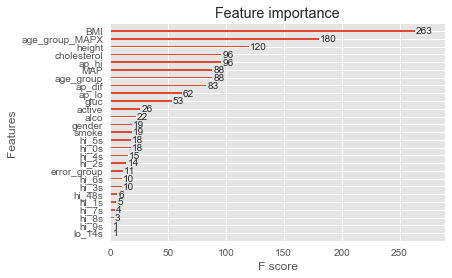

In [125]:
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)
clf.fit(X_train[start_columns], y_train)
for a, b in sorted(zip(clf.feature_importances_, X_train[start_columns].columns)):
    print(a,b, sep='\t\t')
plot_importance(clf)
plt.show()

In [113]:
kf = StratifiedKFold(random_state=12, n_splits=10, shuffle=True)
sfs = SFS(clf, 
           k_features=42, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_log_loss',
#            scoring='accuracy',
           n_jobs=1,
           cv=kf)

In [114]:
sfs = sfs.fit(X_train.values, y_train, start_features=start)


[2017-06-27 16:06:14] Features: 17/42 -- score: -0.538299456162
[2017-06-27 21:09:23] Features: 17/42 -- score: -0.538405185271
[2017-06-28 02:16:03] Features: 18/42 -- score: -0.53825278121
[2017-06-28 07:36:10] Features: 18/42 -- score: -0.538272521954
STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [115]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
17,-0.538299,0.0022399,"[-0.537045272373, -0.538272627864, -0.54125975...","(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 46, 57, 2...",0.00301583,0.00100528
18,-0.538253,0.00229035,"[-0.537205348866, -0.538533965758, -0.54115443...","(2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 46, 57, 233,...",0.00308376,0.00102792


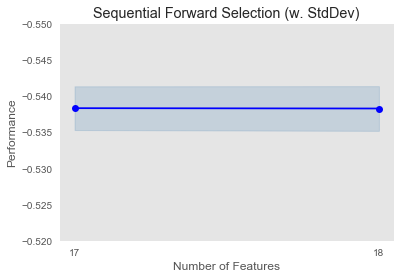

In [116]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([-0.52, -0.55])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [117]:
sfs.get_metric_dict()

{17: {'avg_score': -0.53829945616231434,
  'ci_bound': 0.002239895478996569,
  'cv_scores': array([-0.53704527, -0.53827263, -0.54125976, -0.53478993, -0.53488381,
         -0.5394169 , -0.53923717, -0.54490718, -0.53500922, -0.5381727 ]),
  'feature_idx': (2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   46,
   57,
   233,
   237,
   238,
   240),
  'std_dev': 0.0030158293012411625,
  'std_err': 0.0010052764337470542},
 18: {'avg_score': -0.53825278120967868,
  'ci_bound': 0.0022903494916354434,
  'cv_scores': array([-0.53720535, -0.53853397, -0.54115444, -0.53490584, -0.53432347,
         -0.53934024, -0.53902067, -0.54510376, -0.53509273, -0.53784734]),
  'feature_idx': (2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   46,
   57,
   233,
   237,
   238,
   240,
   241,
   119),
  'std_dev': 0.0030837613503516305,
  'std_err': 0.0010279204501172101}}

In [118]:
for i in (2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   46,
   57,
   233,
   237,
   238,
   240,
   241,
   119):
    print(X_train.columns[i])

gender
height
ap_hi
ap_lo
cholesterol
gluc
smoke
alco
active
error_group
lo_14s
hi_2s
BMI
ap_dif
MAP
age_group
age_group_MAPX
hi_48s


In [21]:
X_train['lo_14s'].value_counts()

0    69965
1       35
Name: lo_14s, dtype: int64